# YOLOv3: An Incremental Improvement
- pdf : https://pjreddie.com/media/files/papers/YOLOv3.pdf

- 참조 사이트 : 
https://wingnim.tistory.com/56


In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## 목차 : 

  1) CNN(Convolution Neural Network)

  2) YOLO 란??
  
  3) YOLO는 어떻게 BOX를 잡을까
  
  4) 

# 1) CNN

## 1.1. CNN이란?
- 사람과 풍경 이미지에서 사람 이미지를 출력하기 위해서는 사람의 이미지에 가중치를 특화하여 이용하겠다는 의미.
- CNN은 **합성 곱(곱해서 더한다)**을 이용해서 **필터(특징 맵)**에 있는 값과 이미지를 이용, 특징을 찾아 계산하겠다는 의미.
- 학습을 통해 사람을 찾기 위한 필터로 훈련시키는 의미.
- ReLU를 사용해서 불필요한 데이터를 제거. 연산속도를 증가.
- CNN : 필터링을 통해 불필요한 데이터를 날리기 때문에 이미지의 압축의 효과도 있음.
- 필터는 CNN의 가중치가 된다. -> CNN 모델을 사용한다 == 업데이트 된 필터를 사용한다.


## 1.2. Keras의 CNN 레이어는 총 두 종류가 있어요
### 1. Conv2D
- 필터의 이동이 가로, 세로로 움직인다.
- 이미지 분석을 위해 사용되어지는 일반적인 합성곱 레이어

### 2. Conv1D
- 필터의 이동이 한쪽 방향으로만 움직인다.
- 텍스트 분석에 사용되는 레이어( char CNN )
- 오타에 안전한 딥러닝 모델을 만들기 위해 사용.. great = greaat


## 1.3. Pooling 또는 Subsampling

- 정해진 구역 안에서 특정한 값을 추출하는 기법
- 입력 데이터 크기를 축소시키고, 학습하지 않아 파라미터가 줄어 오버피팅(Overfitting)이 발생하는 것을 방지한다.
- 합성곱 층이 많은양의 메모리를 필요로 하기 때문에 계산량을 줄여주기 위해 부표본(subSample)을 만드는데, 이는 측면에서 큰 장점이 있다.
- MaxPooling(최댓값을 추출), MinPooling(최솟값을 추출), AveragePooling(평균값을 추출) 등이 있다.

# 2) YOLO는 어떻게 박스를 잡을까?


## 2.1. Bounding Box Prediction
- 클러스터링을 통해 앵커 박스(anchor Box)를 생성하여  bounding box(학습 모델이 예측한 물체 위치)를 예측함.
- 기존 YOLO는 grid의 중심점을 예측했었다면, YOLO_v2 이후부터는, 좌측 상단 모서리를 기준으로 **얼마만큼 이동하고($b_x, b_y$)**, 앵커 박스의 너비와 높이를 **얼마만큼 비율로 조정할 것인지를, 지수승을 통하여 예측($b_w, b_h$)**한다.

$b_x = \sigma (t_x) + c_x $

$b_y \ \sigma (t_y) + c_y $

$b_w = p_w \cdot e^{t_w} $

$b_h = p_h \cdot e^{t_h}$

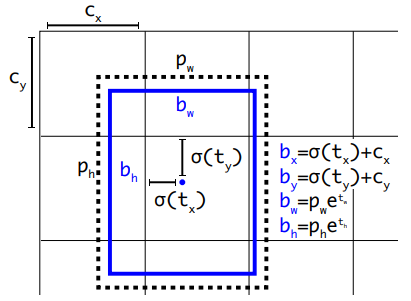

### [Bounding Box Prediction 관련 파라미터 ]

  - $ c_x, c_y$ : grid셀의 **좌측 상단 모서리 좌표(offsets)**
  - $ p_w, p_h$ : 앵커 박스의 너비 및 높이
  - $ t_x, t_y, t_w, t_h$ : YOLO가 예측해야하는 물체의 좌표 값 (Bounding Box)
  - $ b_x, b_y, b_w, b_h$ : 위에서 언급한 값들을 조정하여 실제 GT(Ground Truth, 라벨 값, 정답)와 IOU(Intersection Over Union)를 계산할 최종 bounding box의 offsets값들
    - $b_x, b_y$ : Sigmoid 함수를 통해 $t_x, t_y$ 값을 0~1 사이의 값으로 초기화

### ??? IOU, GT가 뭘까 ???

- IOU (Intersection Over Union)
    - 두 영역의 **교차 영역의 넓이를 합 영엯의 값으로 나눈 값**
    
    $IOU = \frac {<실제BoundingBox> \quad \cap \quad <예측BoundingBox>}{<실제BoundingBox> \quad \cup \quad <예측BoundingBox>} $
    - 객체 검출에서 예측된 경계 상자의 정확도를 평가하는 지표 중 하나로 사용됨.
    - 예측된 경계 상자와 **실제 참값(GT : Ground Truth)** 경계 상자의 IOU를 해당 경계 상자의 ‘정확도’로 간주함
    - 객체 검출 모델의 정확도는 모델을 테스트용 데이터셋에서 실행해본 다음 정밀도-재현율 곡선(precision-recall curve)과 평균 정밀도(average precision)를 구해 수치화할 수 있는데, 이 과정에서 IOU 값이 사용됨.
    

- GT(Ground Truth) : 실제 참값


참조 : https://inspace4u.github.io/dllab/lecture/2017/09/28/IoU.html

- 훈련동안 Sum of Squared Error(오차 제곱합)을 loss 함수로 사용한다.
- YOLOv3은 로지스틱 회귀(or sigmoid function)를 사용하여 각 바운딩 박스에 대한 objectness(객관성) 점수를 예측 -> 바운딩 박스 안에 물체 유무 판단.
- 다른 여러 앵커 박스(Bounding box prioir)보다 실제 물체(GT or Ground Truth Object)와 많이 겹치는 앵커 박스. 즉, IOU가 높은 앵커 박스를 1이라 칭하여 매칭한다. 

$Objectness Score = GT(Object) * IOU$

or

$Confidence Score = Pr(Object) * IOU$ -> YOLOv1
- 그 외의 박스(Best는 아니지만, 임계값 이상으로 실제 개체와 겹치는 경우 또는 객체에 앵커 박스가 할당되지 않는 경우 등)에는 예측을 무시한다.
- IOU의 임계값(thershold)은 0.5를 사용 (보통, 물체 두개가 2/3 이상이 되어야 임계값이 0.5가 된다.)
- 임계 : 사물이 어떠한 기준에 의하여 분간되는 한계

- 참조 : https://ballentain.tistory.com/12

## 2.2. Class prediction 
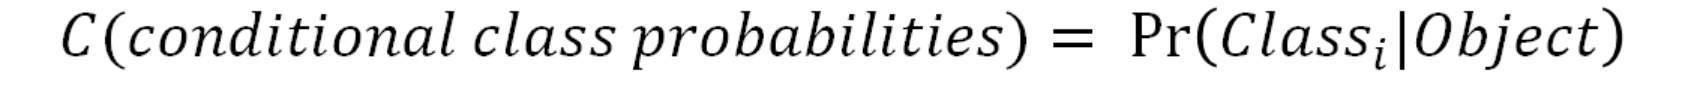

- YOLO에서는 어떻게 클래스를 예측할까? -> YOLOv1
    - 위의 식은 그리드 셀 안에 객체가 있다는 조건 하, 그 객체가 어떤 클래스(class)인지에 대한 조건부 확률이다.
    - 그리드 셀에 있는 Bounding Box와는 상관없이, 오직 1개의 Class에 대한 확률 값을 구한다.
    - class에 대한 신뢰도 점수(class-specific confidence score)는 다음과 같다.
    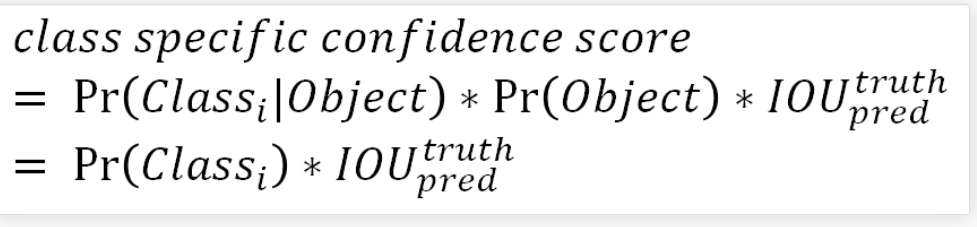
    
    - 이는 bounding box에 특정 Class 객체가 나타날 확률($Pr(Class_i)$)과 예측된 Bounding Box가 그 Class에 얼마나 잘 맞는지(fits the object)(=$IOU_{pred}^{truth}$)를 나타낸다
    - 참조 사이트 : https://bkshin.tistory.com/entry/%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-YOLOYou-Only-Look-Once

--------------------------------------------------------------------------------------------------------------
- 각 Box는 다중 분류(Mulit-label classification)를 사용하여 Bounding Box를 포함할 수 있는 class등을 예측한다
    - 다중 레이블 접근은 데이터를 더 잘 모델링한다.
    
- Class Prediction : Logistic Classifiers(로지스틱 분류기)를 사용함(Softmax보다 더 좋은 성능을 낸다)
    - Logistic Classifiers : Sigmoid, ReLu, tanh 등
    - Softmax를 사용하게 되면, 각 박스들은 정확하게 하나의 클래스를 가정하는데, 이는 종종 옳지 않은 결과를 보인다.
    
- Loss Function : 이중 교자 엔트로피(binary cross-entropy)를 class 예측을 위해 사용한다,
    - 그래서, multi_class classification에서 사용되는 loss 함수인, categorical cross entropy loss를 사용하지 않음.  

## 2.3. Predictions Across Scales
  - YOLOv3에서는 세 가지의 다른 scales에서 boxes를 예측한다.
  - Pyramid Networks를 특징과 유사한 개념을 사용하여, 이 scales에서 특징을 추출한다.
  - 논문에서는 COCO Data sets를 이용하였고 각 scales에서 3개의 박스를 생성하여 진행했다.
    
     - 하나의 Feature Map에서 output 형태 : N × N × [3 ∗ (4 + 1 + 80)] 
        - Bounding Box : 3개
        - Bounding Box Offsets : 4개
        - Objectness prediction : 1개
        - Class predictions : 80개
        - N : input image 나누는  Grid(격자) 크기. ex) 147 * 147 크기의 이미지를 7 * 7 크기의 격자로 로 나누기.
  - 앵커 박스(Bounding Box Priors)를 결정하기 위해 k-means clustering을 사용
  - 세 가지의 다른 scales를 이용하며, 이에 각 scales에 3개의 박스를 생성하기 때문에, 총 9개의 cluster를 사용한다.
  - COCO Data sets에서 사용한 앵커 Box 형태 :
         - (10×13),(16×30),(33×23),(30×61),(62×45),(59×119),(116 × 90),(156 × 198),(373 × 326)

## 2.4. Feature Extractor 

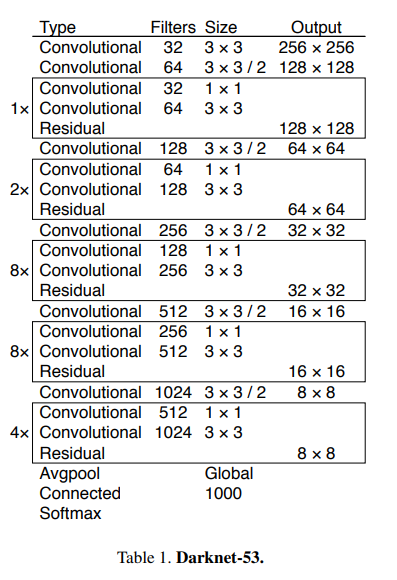

## YOLO를 불러와서 실제로 실행해보자 

참조 : https://blog.naver.com/co748/221554688233

### 1. DarkNet 설치하기
- DarknNet란?
  - C와 CUDA로 작성된 오픈소스 신경망 프레임 워크. 빠르고 설치가 쉽고 CPU 및 GPU 계산을 지원.
  - 가성환경에서 아래의 코드를 실행한다.
  
- Yolov3을 실행하기 위해서는 python 3.6 version의 가상환경이 필요.

#clone repository 

git clone https://github.com/thtrieu/darkflow 

cd DarkFlow

​

 #build

 python3 setup.py build_ext --inplace

 pip install -e .
 pip install .

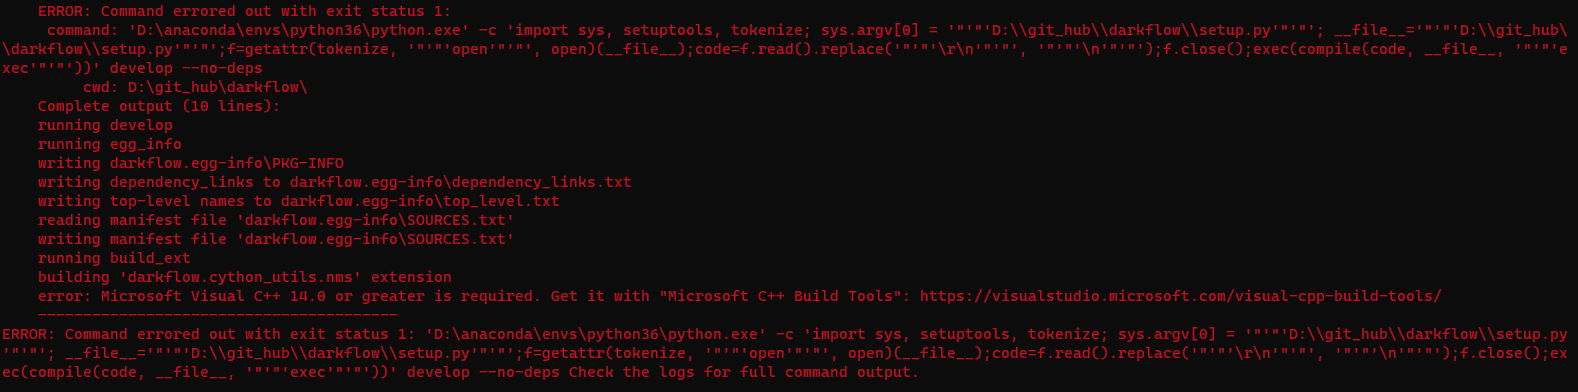

- 위와 같은 오류가 발생했을 시, Microsoft Build Tools를 설치해주면 된다.

참조 : https://somjang.tistory.com/entry/Python-pip-install-%EC%8B%9C-error-Microsoft-Visual-C-140-is-required-%EC%98%A4%EB%A5%98-%ED%95%B4%EA%B2%B0-%EB%B0%A9%EB%B2%95

### 3. 가중치 다운 받기
https://pjreddie.com/media/files/yolov3.weights

https://pjreddie.com/media/files/yolov3-tiny.weights


### 4. 가중치 이용하기
- 받은 가중치를 darkflow 폴더에 bin이란 폴더를 생성하고, 여기에 넣어준다.
- python flow --imgdir input --load model.weights --model model.cfg --labels darkflow/labels.txt 으로 파일 실행하기

- No module named 'tensorflow.contrib' 오류
- tensorflow 버전이 맞지 않아서 그렇다!
- tensorflow 1.14 이후 버전에 대해서 tensorflow.contrib 지원을 하지 않는다.
- 따라서 이전 tensorflow 버전을 삭제하고 아래의 코드를 입력, 1.14 버전을 설치한다.
  - conda install tensorflow==1.14
  - conda install tensorflow-gpu==1.14
  

- darkflow/input에 검출 하고자 하는 사진을 넣어준다 .

In [15]:
from darkflow.net.build import TFNet
import cv2

options = {"model": "./darkflow/cfg/yolov3.cfg", "load": "./darkflow/bin/yolov3.weights", "threshold": 0.1}

tfnet = TFNet(options)

imgcv = cv2.imread("./darkflow/input/shoes_and_man.jpg")
# print(imgcv)
result = tfnet.return_predict(imgcv)
print(result)

Parsing ./darkflow/cfg/yolov3.cfg


NameError: name 'exit' is not defined

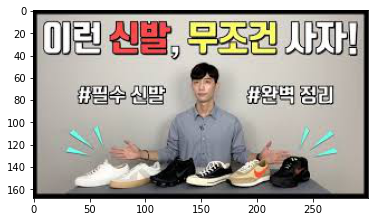

In [8]:
import matplotlib.pyplot as plt
imgcv = cv2.imread()
plt.imshow(cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB))
